# Transfer Learning with Keras

Transfer learning is to transfer the trained model parameters to the new model to help the new model training. Considering that most data or tasks are related, we can share the learned model parameters with the new model in some way through transfer learning to speed up and optimize the learning efficiency of the model. It is different from most networks and does not require learning from scratch.

Next, I will introduce how to use tranfer learning and compare it with simple CNN  
接下來我將介紹tranfer learning如何使用，並將其與簡單CNN做比較

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [2]:
import glob
import numpy as np
import os
import shutil

np.random.seed(46)

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

## Load the data

We can see that there are 1000 pictures of cats and dogs each  
我們可以看到貓和狗的圖片各有1000張

In [4]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(1000, 1000)

In order to prove that transfer learning can get good results by using a small number of pictures, I took out 50 pictures of each of 2000 cats and dogs as training data, 20 pictures of each as validation data, and 500 pictures of each as test data.  

為了證明transfer learning使用少量圖片就可以得到不錯的結果，所以我從2000張貓和狗的圖片中取出各50張當trainning data，取出各20張圖片當validation data，取出各500張當test data。

In [5]:
# We build a smaller dataset
cat_train = np.random.choice(cat_files, size=50, replace=False)  
dog_train = np.random.choice(dog_files, size=50, replace=False)  
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=20, replace=False)  
dog_val = np.random.choice(dog_files, size=20, replace=False) 
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False) 
dog_test = np.random.choice(dog_files, size=500, replace=False) 

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (50,) (20,) (500,)
Dog datasets: (50,) (20,) (500,)


I put the separated pictures into the training_data, validation_data, test_data folders, and they can be used directly next time  
我將分出的圖片分別放入資料夾training_data、validation_data、test_data中，下次就可以直接使用了

In [6]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

shutil.rmtree('training_data')
shutil.rmtree('validation_data')
shutil.rmtree('test_data')

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

# Load of the actual images
In this step, I load the image in, and for the convenience of training, I changed the image size to 150x150, and then set the label  
這一步我將圖片load進來，並為了方便做訓練所以把圖片大小改為150x150,然後設定label

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]
# MAC '/', WINDOWS '\\'

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape,
      '\nTest dataset shape:', test_imgs.shape)

Train dataset shape: (100, 150, 150, 3) 
Validation dataset shape: (40, 150, 150, 3) 
Test dataset shape: (1000, 150, 150, 3)


Some APIs convert the input number into a decimal between 0 and 1 before processing. In order to maintain accuracy, we first divide the value by 255 and convert it to a decimal between 0 and 1.  

有些API會將輸入的數字轉換成0到1之間的小數再進行處理，為了保持精度所以我們先將數值除以255轉成0到1之間的小數

In [8]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled = test_imgs.astype('float32')

train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

print(train_imgs_scaled[0])

[[[139. 139. 137.]
  [141. 141. 139.]
  [142. 142. 140.]
  ...
  [169. 168. 164.]
  [164. 164. 152.]
  [165. 165. 153.]]

 [[139. 139. 137.]
  [141. 141. 139.]
  [142. 142. 140.]
  ...
  [173. 172. 168.]
  [167. 167. 157.]
  [173. 173. 163.]]

 [[141. 141. 139.]
  [141. 141. 139.]
  [141. 141. 139.]
  ...
  [177. 172. 169.]
  [170. 169. 164.]
  [176. 175. 170.]]

 ...

 [[159. 161. 148.]
  [159. 161. 148.]
  [159. 161. 148.]
  ...
  [164. 164. 152.]
  [162. 164. 151.]
  [162. 164. 151.]]

 [[160. 162. 148.]
  [160. 162. 148.]
  [160. 162. 148.]
  ...
  [162. 162. 150.]
  [162. 164. 151.]
  [162. 164. 151.]]

 [[159. 164. 160.]
  [159. 164. 157.]
  [159. 165. 153.]
  ...
  [164. 165. 151.]
  [163. 164. 150.]
  [163. 164. 150.]]]


Here we set batch_size (determine how many samples are used for one training), num_classes (there are several training categories), epochs (how many times to train), input_shape (shape of the picture), and do LabelEncoder (standardize the label), 0 means cat , 1 for dog

這邊我們設定batch_size(決定一次訓練使用多少樣本數)、num_classes(有幾個訓練類別)、epochs(訓練幾次)、input_shape(圖片的shape)，並做LabelEncoder(將label標準化)，0代表貓，1代表狗

In [9]:
batch_size = 64
num_classes = 2
epochs = 15
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[0:5], train_labels_enc[0:5])
print(train_labels[51:56], train_labels_enc[51:56])

['cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0]
['dog', 'dog', 'dog', 'dog', 'dog'] [1 1 1 1 1]


我們可以看到，我們的編碼方案的數量分配0給cat標籤和1給dog標籤。現在，我們準備構建我們的第一個基於CNN的深度學習模型。

# CNN Model
In order to compare the difference between simple CNN and transfer learning, I have first built a simple CNN model  
為了比較簡單CNN與transfer learning之間的差異，我已我先建一個簡單CNN的模型

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [11]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
2/2 [==============================] - 3s 1s/step - loss: 3.0239 - accuracy: 0.4577 - val_loss: 1.6058 - val_accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 1s 598ms/step - loss: 1.3954 - accuracy: 0.5156 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/15
2/2 [==============================] - 1s 574ms/step - loss: 0.6841 - accuracy: 0.5304 - val_loss: 0.6923 - val_accuracy: 0.5250
Epoch 4/15
2/2 [==============================] - 1s 594ms/step - loss: 1.0556 - accuracy: 0.6833 - val_loss: 0.7159 - val_accuracy: 0.5000
Epoch 5/15
2/2 [==============================] - 1s 616ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5500
Epoch 6/15
2/2 [==============================] - 1s 612ms/step - loss: 0.6412 - accuracy: 0.7975 - val_loss: 0.7625 - val_accuracy: 0.5000
Epoch 7/15
2/2 [==============================] - 1s 554ms/step - loss: 0.6216 - accuracy: 0.5675 - val_loss: 0.6840 - val_accuracy: 0.5500
Epoch 8/15
2/2 [=======

I transferred Accuracy and Loss as icons to see the changes of Accuracy and Loss during training of this model  
我將Accuracy及Loss轉出為圖標方便看這個模型訓練時Accuracy及Loss的變化

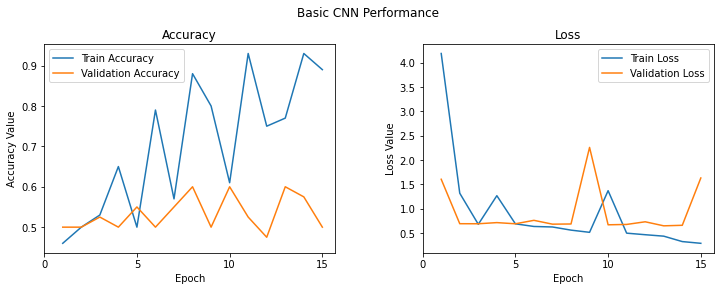

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
#由于keras库版本的不同，这次将acc改为accuracy之后，就不會出錯誤了
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') 
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can see that the training effect is not very good, but when we use the test data to get the Accuracy, the Accuracy is only 50%  
我們可以看到訓練出來效果不太好，然用我們用test data去取Accuracy，Accuracy也只有50%

In [13]:
scores = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 50.20%


## 預訓練的CNN模型作為特徵提取器

Load the VGG-16 model and freeze the convolution blocks, because we don’t want to change their weights during model training, and use VGG-16 as an image feature extractor  
載入VGG16模型並凍結卷積塊，因為我們不希望在模型訓練期間改變它們的權重，並將VGG-16用作為圖像特徵提取器

In [14]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

<ipython-input-14-4bc125196904>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D339FF1B20>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D339FF1F40>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D339F7FDF0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D339FF8280>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D33A0094F0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D33A0157C0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D33A010130>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D339FFFC70>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D33A020160>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D33A024490>,block3_conv3,False


We first throw our data into the VGG-16 model for feature extraction  
我們先將我們的資料丟到vgg16模型中，進行特徵的萃取

In [15]:
%%time

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)
test_features_vgg = get_bottleneck_features(vgg_model, test_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\nValidation Bottleneck Features:', validation_features_vgg.shape,
      '\ntest Bottleneck Features:', test_features_vgg.shape)

Train Bottleneck Features: (100, 8192) 
Validation Bottleneck Features: (40, 8192) 
test Bottleneck Features: (1000, 8192)
Wall time: 1min 17s


We have taken out the features, and then we have to make a classifier to train the features just taken out  
我們已經將特徵取出，接下來我們要做一個分類器將剛剛取出的特徵進行訓練

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr =1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
2/2 [==============================] - 1s 170ms/step - loss: 0.7626 - accuracy: 0.4977 - val_loss: 0.6593 - val_accuracy: 0.5500
Epoch 2/15
2/2 [==============================] - 0s 46ms/step - loss: 0.6120 - accuracy: 0.6083 - val_loss: 0.6228 - val_accuracy: 0.6250
Epoch 3/15
2/2 [==============================] - 0s 40ms/step - loss: 0.5669 - accuracy: 0.7292 - val_loss: 0.5765 - val_accuracy: 0.8000
Epoch 4/15
2/2 [==============================] - 0s 40ms/step - loss: 0.4739 - accuracy: 0.8175 - val_loss: 0.5563 - val_accuracy: 0.8000
Epoch 5/15
2/2 [==============================] - 0s 46ms/step - loss: 0.4646 - accuracy: 0.8294 - val_loss: 0.5355 - val_accuracy: 0.7750
Epoch 6/15
2/2 [==============================] - 0s 46ms/step - loss: 0.3619 - accuracy: 0.8865 - val_loss: 0.5270 - val_accuracy: 0.7750
Epoch 7/15
2/2 [==============================] - 0s 45ms/step - loss: 0.3248 - accuracy: 0.9444 - val_loss: 0.5134 - val_accuracy: 0.7750
Epoch 8/15
2/2 [==========

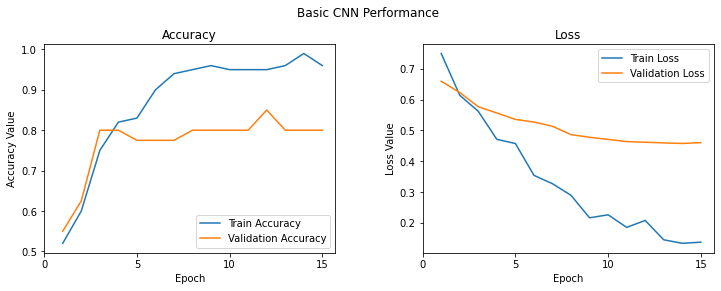

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
#由于keras库版本的不同，这次将acc改为accuracy之后，就不會出錯誤了
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') 
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can see that the result is pretty good, Accuracy reached 83%  
我們可以看到結果還不錯，Accuracy達到83%

In [19]:
scores = model.evaluate(test_features_vgg, test_labels_enc, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.10%


# Create a complete new network and use it for inference

Reference: https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e

In [20]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

Load a VGG-16 model trained with Imagent and remove the last layer, then build a new classifier  
載入一個以Imagent訓練好的VGG16的model並將最後一層移除，然後建立新的分類器

In [21]:
base_model=VGG16(include_top=False, weights='imagenet') #imports the VGG16 model and discards the last layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Set the first 20 layers to be non-trainable to prevent weights from being updated  
將前20層設定為non-trainable避免權重被更新

In [22]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [23]:
len(model.layers)

22

In [24]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [26]:
#step_size_train=train_generator.n//train_generator.batch_size
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                        validation_data=(validation_imgs_scaled, validation_labels_enc),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)

Epoch 1/15
2/2 [==============================] - 11s 6s/step - loss: 0.7758 - accuracy: 0.5185 - val_loss: 0.6015 - val_accuracy: 0.8000
Epoch 2/15
2/2 [==============================] - 10s 5s/step - loss: 0.5688 - accuracy: 0.7352 - val_loss: 0.6399 - val_accuracy: 0.5250
Epoch 3/15
2/2 [==============================] - 9s 5s/step - loss: 0.5641 - accuracy: 0.5971 - val_loss: 0.5365 - val_accuracy: 0.7500
Epoch 4/15
2/2 [==============================] - 9s 5s/step - loss: 0.4578 - accuracy: 0.7894 - val_loss: 0.5302 - val_accuracy: 0.7500
Epoch 5/15
2/2 [==============================] - 9s 5s/step - loss: 0.4220 - accuracy: 0.8390 - val_loss: 0.4557 - val_accuracy: 0.7750
Epoch 6/15
2/2 [==============================] - 9s 5s/step - loss: 0.3577 - accuracy: 0.8465 - val_loss: 0.4422 - val_accuracy: 0.8000
Epoch 7/15
2/2 [==============================] - 9s 5s/step - loss: 0.3349 - accuracy: 0.8627 - val_loss: 0.4319 - val_accuracy: 0.7750
Epoch 8/15
2/2 [=======================

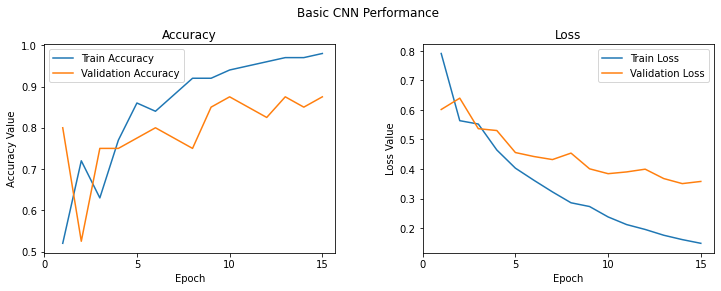

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
#由于keras库版本的不同，这次将acc改为accuracy之后，就不會出錯誤了
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') 
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In fact, it is similar to the previous method. Both use the vgg16 model for data extraction without participating in training. The biggest difference between the two is that the previous method runs vgg16 once to obtain the feature map, and this method runs vgg16 once for each batch. , But does not participate in the training, only the last layer of classifiers are trained. So the result will be similar to the previous method  

其實和上個方法是差不多的，都是把vgg16的model用於資料萃取而不參與訓練，兩者最大差異在於方法一個run一次vgg16來取得特徵圖，而這個方法每個batch都會跑一次vgg16，但是不參與訓練，僅在最後的一層分類器進行訓練。所以出來的結果會和上一個方法差不多

In [28]:
scores = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.80%


From the above results, we can see that using transfer learning can use a small amount of data to get good results, and using transfer learning does not require very advanced equipment, it can run with CPU  

由上面的結果可知，使用transfer learning可以使用少量資料得到不錯的結果，而且使用transfer learning也不需要很高級的設備，使用CPU就可以跑了